In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.widgets import Button

In [2]:
opnames = pd.read_csv("../opnames.csv", delimiter=",")
opnames.head(10)

,ref_spec,adm_icu,dis_icu,los_icu,age,gender,nice_ap4_score,icu_death,plan_adm
0,12,2015-10-17 20:22:00,2015-11-03 10:35:00,16.592361,51,F,28,0,0.0
1,12,2015-10-28 23:15:00,2015-11-05 14:46:00,7.646527,54,M,74,0,0.0
2,9,2015-10-30 14:40:00,2015-11-02 14:18:00,2.984722,77,M,63,0,0.0
3,21,2015-10-31 13:24:00,2015-11-16 14:06:00,16.029166,70,F,84,0,0.0
4,12,2015-11-06 01:39:00,2015-11-06 00:08:00,NaN,56,M,49,0,0.0
5,3,2015-11-24 00:21:00,2015-12-03 13:21:00,9.541666,45,M,44,0,0.0
6,12,2015-11-23 17:19:00,2015-12-06 11:41:00,12.765277,34,F,64,1,0.0
7,2,2015-11-30 13:27:00,2015-12-31 16:31:00,31.127777,67,M,94,0,0.0
8,12,2015-11-23 09:39:00,2015-12-12 07:22:00,18.904861,78,F,99,1,0.0
9,41,2015-11-23 07:40:00,2015-11-28 13:45:00,5.253472,59,M,68,0,0.0


## 1. Data Cleaning

As we have gone over the data cleaning in the User Generation Notebook, we will not go into detail regarding the cleaning of the data.

In [ ]:
chance_of_zero = len(opnames[opnames["plan_adm"] == 0]) / len(opnames) 
np.random.seed(1)
opnames["plan_adm"] = opnames["plan_adm"].fillna(np.random.choice([0, 1], p=[chance_of_zero, 1 - chance_of_zero]))
opnames = opnames.dropna(subset=["los_icu"])

## 2. Data Preperation

In this part we will be focusing on the `ref_spec` column, which describes the Referring Specialty. In other words the part of the hospital a patient will be sent towards accounting for the problem they have.

Let's verify that this column does not contain any NaN's.

In [ ]:
opnames["ref_spec"].isna().sum()

np.int64(0)

We have been supplied with a translation for the numbers that are entered in the `ref_spec` column. These translations are the following:

- NEC: 12
- INT: 2, 4, 7, 41, 47
- CARD: 3
- CHIR: 9, 10, 11, 13, 39
- NEU: 21
- CAPU: 29, 50
- Other: 15, 18, 19, 20, 23, 36, 48, 98


In [ ]:
OPTIONS = {
    "NEC": [12],
    "INT": [2, 4, 7, 41, 47],
    "CARD": [3],
    "CHIR": [9, 10, 11, 13, 39],
    "NEU": [21],
    "CAPU": [29, 50],
    "Other": [15, 18, 19, 20, 23, 36, 48, 98]
}

uniques = np.unique(opnames["ref_spec"])
uniques

array(['10', '11', '12', '13', '15', '18', '19', '2', '20', '21', '23',
       '29', '3', '36', '39', '4', '41', '47', '48', '50', '7', '9', '98',
       'CAPU', 'CARD', 'CHIR', 'INT', 'NEC', 'NEU'], dtype=object)

We have created a dict containing our mapping, but as we can see the data set supplied also has the keys itself in the column as values. We will first check whether the key is the same before parsing the string to a number to prevent errors

In [ ]:
def get_spec(x):
    if x in OPTIONS.keys():
        return x
    
    parsed_x = int(x)

    for option in OPTIONS.keys():
        if parsed_x in OPTIONS[option]:
            return option


opnames["ref_spec_name"] = opnames["ref_spec"].apply(lambda x: get_spec(x))
# opnames["ref_spec_code"] = pd.Categorical(opnames["ref_spec_name"]).codes
opnames.head(10)

,ref_spec,adm_icu,dis_icu,los_icu,age,gender,nice_ap4_score,icu_death,plan_adm,ref_spec_name
0,12,2015-10-17 20:22:00,2015-11-03 10:35:00,16.592361,51,F,28,0,0.0,NEC
1,12,2015-10-28 23:15:00,2015-11-05 14:46:00,7.646527,54,M,74,0,0.0,NEC
2,9,2015-10-30 14:40:00,2015-11-02 14:18:00,2.984722,77,M,63,0,0.0,CHIR
3,21,2015-10-31 13:24:00,2015-11-16 14:06:00,16.029166,70,F,84,0,0.0,NEU
5,3,2015-11-24 00:21:00,2015-12-03 13:21:00,9.541666,45,M,44,0,0.0,CARD
6,12,2015-11-23 17:19:00,2015-12-06 11:41:00,12.765277,34,F,64,1,0.0,NEC
7,2,2015-11-30 13:27:00,2015-12-31 16:31:00,31.127777,67,M,94,0,0.0,INT
8,12,2015-11-23 09:39:00,2015-12-12 07:22:00,18.904861,78,F,99,1,0.0,NEC
9,41,2015-11-23 07:40:00,2015-11-28 13:45:00,5.253472,59,M,68,0,0.0,INT
10,9,2015-12-01 18:10:00,2016-01-05 18:34:00,35.016666,69,M,58,0,0.0,CHIR


Lastly we will create a column describing which age group a patient is part of. Age groups will be helpful later on when creating certain distribution. For example when taking an age group into account for the average time spent in the ICU, will give us a more realistic view of the average than taking the entire dataset.

[https://www.statcan.gc.ca/en/concepts/definitions/age2]

The source above gives as a few age groupings which are: Children (0-14), Youth (15-24), Adults (25-64), Seniors (65>)

In [ ]:
bins = [0, 14, 24, 64, 1000]
labels = ['child', 'youth', 'adult', 'senior']
opnames["age_group"] = pd.cut(opnames['age'], bins=bins, labels=labels, right=True)

## 3. Data Visualization

Let's start visualizing the data and determining what ratio's and distributions can help us in creating a more accurate simulation.

We start of by visualizing the amount of patients going to each specialization.

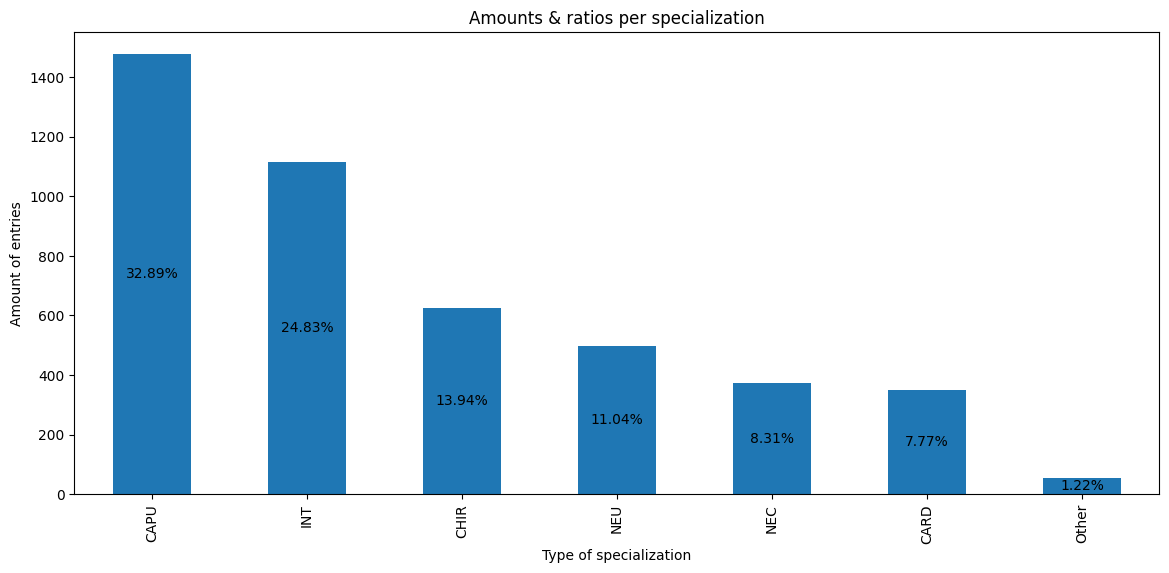

In [ ]:
value_counts = opnames["ref_spec_name"].value_counts()

ratios = value_counts / len(opnames)

ax = value_counts.plot(kind="bar", figsize=(14, 6))

for i, (count, ratio) in enumerate(zip(value_counts, ratios)):
    ax.text(i, count / 2, f"{ratio:.2%}", ha="center", va="center")

plt.title("Amounts & ratios per specialization")
plt.ylabel("Amount of entries")
plt.xlabel("Type of specialization")
plt.show()

We can use the ratios displayed in the graph above to supply probabilaties to a function when choosing what type of issue a patient should have. 

Next we move onto displaying the average amount of time is spent per specializaiton.

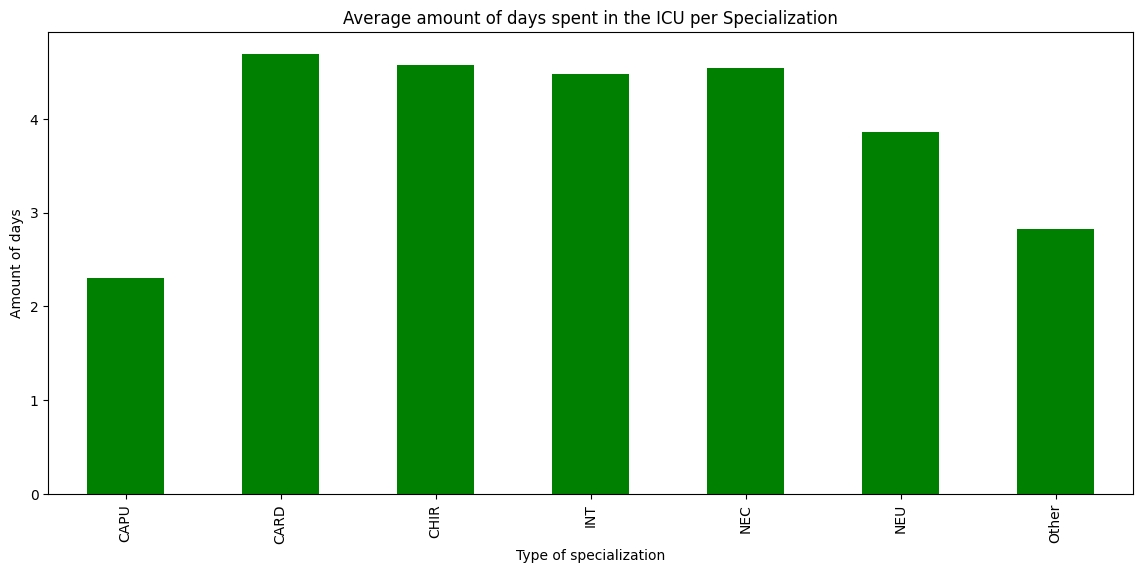

In [ ]:
ref_spec_grouped = opnames.groupby("ref_spec_name")
ref_spec_grouped["los_icu"].mean().plot(kind="bar", figsize=(14, 6), color="green")

plt.title("Average amount of days spent in the ICU per Specialization")
plt.ylabel("Amount of days")
plt.xlabel("Type of specialization")
plt.show()

In the User Generation Notebook we used the opnames dataset to create distributions of the `age`, `gender`, `planned or unplanned`, `time spent in icu` columns. This would help us create more accurate patients that would be represented by agents in our simulation. However in the previous notebook we did not account for the specialization. 

We believe that the distributions will be more representative of the real world when taking the specialization into account.



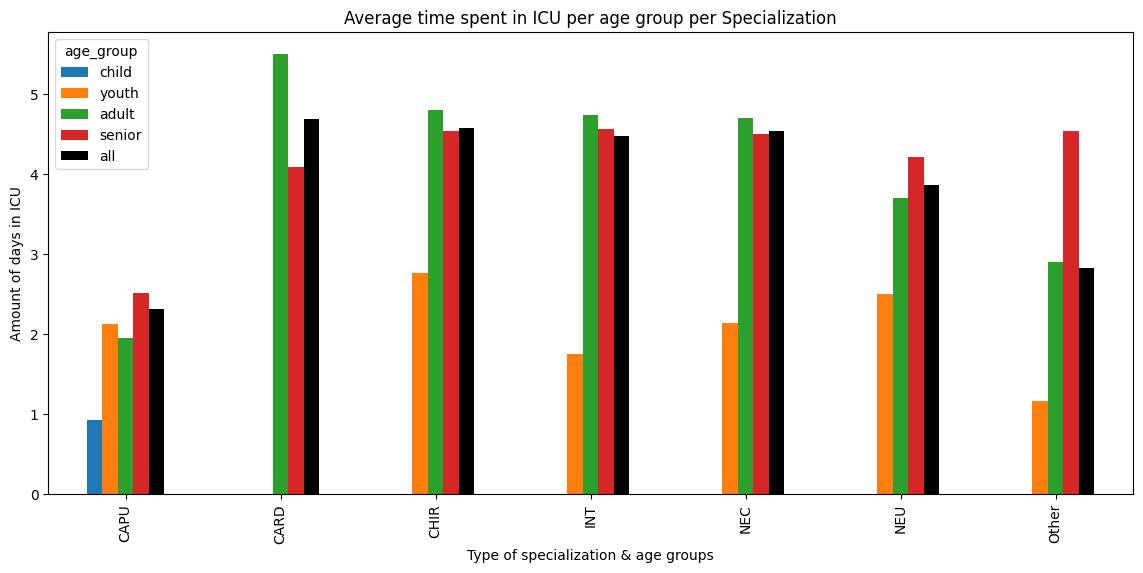

In [ ]:
ref_spec_age_grouped = opnames.groupby(by=["ref_spec_name", "age_group"], observed=True)
data = ref_spec_age_grouped["los_icu"].mean().unstack()#.plot(kind="bar", figsize=(15, 6))
data["all"] = ref_spec_grouped["los_icu"].mean()

ax = data.plot(kind="bar", figsize=(14, 6), color=[*plt.cm.tab10.colors[:len(data.columns) - 1], "black"])

plt.title("Average time spent in ICU per age group per Specialization")
plt.xlabel("Type of specialization & age groups")
plt.ylabel("Amount of days in ICU")
plt.show()



The graph above indicates the average time that was spent in the ICU (in days), per age group per specialization. The black bar that has been added for each specialization indicates the average for that specialization when all age groups were combined. For almost all cases the `youth` age group differs quite a lot from the original average. 

So when using the age groups we get a better view for each patient per specialization for their average duration in the ICU.

Lets continue with looking at the way the age is distrubited in each specialization.

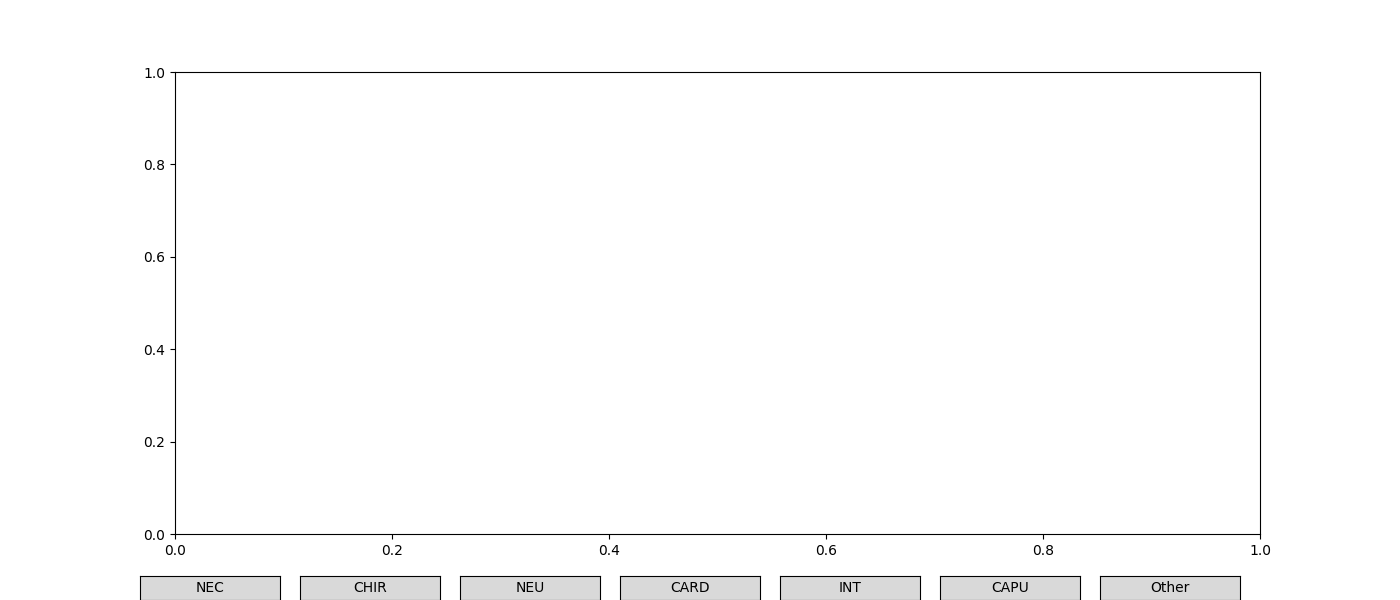

In [ ]:
import ipympl
unique_ref_specs = opnames["ref_spec_name"].unique()

fig, ax = plt.subplots(figsize=(14, 6))

button_axes = []
buttons = []

def update_hist(ref_spec):
    ax.clear()
    ages = ref_spec_grouped.get_group(ref_spec)["age"]
    ax.bar(ages.value_counts().index, ages.value_counts())
    ax.set_title(f"Age distribution for {ref_spec}")    
    ax.set_xlabel("Age")
    ax.set_ylabel("Frequency")
    plt.draw()

def on_click(event):
    update_hist(event.inaxes.get_label())

%matplotlib widget

for i, ref_spec in enumerate(unique_ref_specs):
    button_ax = fig.add_axes([0.1 + i * (0.8 / len(unique_ref_specs)), 0, 0.1, 0.04])
    button = Button(button_ax, ref_spec)
    button.ax.set_label(ref_spec)
    button.on_clicked(on_click)
    buttons.append(button)

We move onto checking the distribution of gender for each different specialization group. And as you can see in the graph below, the distributions are very divided. Some specializations have more women than men and with others its visa versa. 

Splitting the gender distributions like this has given us a much better view on the actual distributions of gender.

998 479
233 116
454 172
669 446
182 191
293 203
16 39


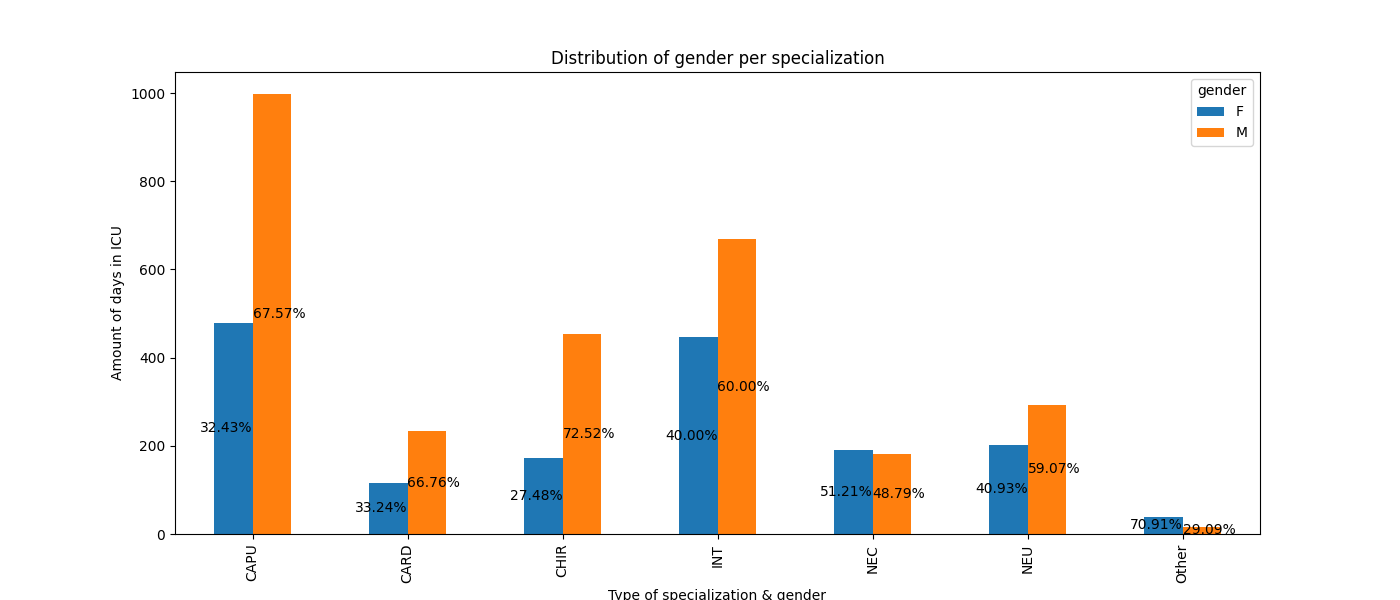

In [ ]:
data = ref_spec_grouped["gender"].value_counts().unstack()
# print(data)
ax = data.plot(kind="bar", figsize=(14, 6), color=plt.cm.tab10.colors[:len(data.columns)])


for i, key in enumerate(data.index):
    tmp = ref_spec_grouped.get_group(key)
    M = len(tmp[tmp["gender"] == "M"])
    F = len(tmp[tmp["gender"] == "F"])
    print(M, F)
    ratio_M = M / len(tmp)
    ratio_F = F / len(tmp)

    ax.text(i, M / 2, f"{ratio_M:.2%}", ha="left", va="center")
    ax.text(i, F / 2, f"{ratio_F:.2%}", ha="right", va="center")
plt.title("Distribution of gender per specialization")
plt.xlabel("Type of specialization & gender")
plt.ylabel("Amount of days in ICU")
plt.show()

Last but not least we will dive into the unplanned against planned distributions. These are needed to generate the correct amount of unplanned and planned patients that will enter the hospital looking for help.

157 1320
343 6
506 120
1096 19
326 47
487 9
54 1


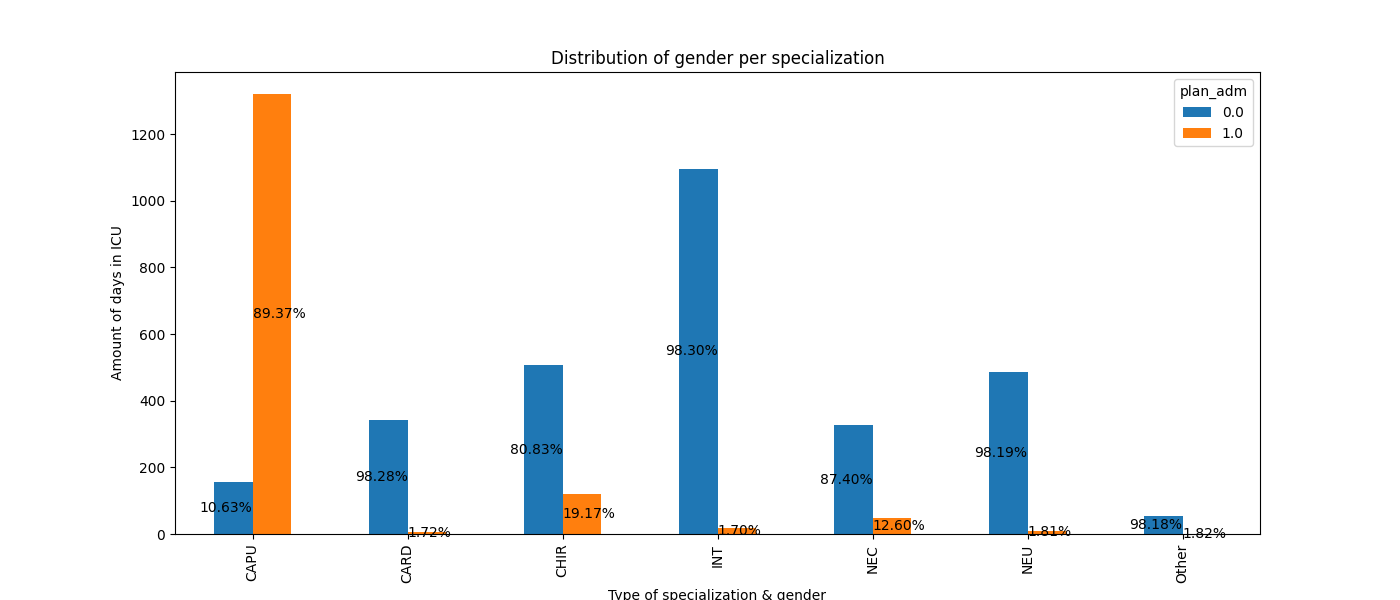

In [ ]:
data = ref_spec_grouped["plan_adm"].value_counts().unstack()
# print(data)
ax = data.plot(kind="bar", figsize=(14, 6), color=plt.cm.tab10.colors[:len(data.columns)])


for i, key in enumerate(data.index):
    tmp = ref_spec_grouped.get_group(key)
    U = len(tmp[tmp["plan_adm"] == 0])
    P = len(tmp[tmp["plan_adm"] == 1])
    print(U, P)
    ratio_U = U / len(tmp)
    ratio_P = P / len(tmp)

    ax.text(i, U / 2, f"{ratio_U:.2%}", ha="right", va="center")
    ax.text(i, P / 2, f"{ratio_P:.2%}", ha="left", va="center")
plt.title("Distribution of gender per specialization")
plt.xlabel("Type of specialization & gender")
plt.ylabel("Amount of days in ICU")
plt.show()